# R.O.C.N.E.T. Regression of Crypto Network

In this project, we will investigate using LSTMs and GRUs to predict the future price of cryptocurrencies. We will conduct a few experiments to see if we can improve the performance of the model. 

In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import torch
import torch.nn as nn
import random
import time
import datetime
import praw

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preprocessing
First, we preprocess our data. We will use only historic price, though it may be possible in future to use other features such as market-cap etc. but we will restrict that for now. The following code can process the data (price history) for an individual file/cryptocurrency. 

In [2]:
def split_data(data_raw, lookback):
    test_percent = 0.2
    val_percent = 0.1
    data = []
    # create all possible sequences of length 'lookback'
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_size = int(np.round(test_percent*data.shape[0]))
    val_size = int(np.round(val_percent*data.shape[0]))
    train_size = data.shape[0] - test_size - val_size
    
    x_val = data[:val_size,:-1]
    x_val = torch.from_numpy(x_val).type(torch.Tensor)
    
    y_val = data[:val_size,-1]
    y_val = torch.from_numpy(y_val).type(torch.Tensor)
    
    x_train = data[val_size:train_size + val_size,:-1]
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    
    y_train = data[val_size:train_size + val_size,-1]
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    
    x_test = data[-test_size:,:-1]
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    
    y_test = data[-test_size:,-1]
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

## Importing data/ Preprocessing continued
We now import the data, which is the historic price of the cryptocurrencies we wish to look at. In our directory there is a file with respect to each of the cryptocurrencies. 

Note that we need to scale the data because the LSTMs/GRUs do not 'play well' with data on a wide scale, especially considering that some will fluctuate in the range of \\$0.01 to \\$0.1, while others in the hundreds of dollars scale. It is for this reason that we use a common scale between 0 and 1 for all the cryptocurrencies. (Testing the models without scaling the data yielded very bad results).

In these experiments, there was no attempt to upscale the data back to their original scales, though this would be possible, however it was not deemed a relevant part of these experiments. 

In [3]:
cryptos_names = list()
cryptos_prices = list()
scaler = MinMaxScaler(feature_range=(0, 1))
lookback = 40 # sequence length for lstm/gru
for filename in os.listdir("./crypto_price/"):
    if filename.endswith(".csv"):
        cryptos_names.append(filename.strip(".csv").split("_")[1])
        data = pd.read_csv("./crypto_price/" + filename)
        price = data[['Close']].to_numpy()
        price = scaler.fit_transform(price.reshape(-1,1))
        x_train, y_train, x_val, y_val, x_test, y_test = split_data(price, lookback)
        cryptos_prices.append([x_train, y_train, x_val, y_val, x_test, y_test])

We can inspect the cryptocurrencies which we have available to us:

In [4]:
cryptos_names, cryptos_prices

(['Aave',
  'BinanceCoin',
  'Bitcoin',
  'Cardano',
  'ChainLink',
  'Cosmo',
  'CryptocomCoin',
  'Dogecoin',
  'EOS',
  'Ethereum',
  'Iota',
  'Litecoin',
  'Monero',
  'NEM',
  'Polkadot',
  'Solana',
  'Stellar',
  'Tether',
  'Tron',
  'USDCoin',
  'Uniswap',
  'WrappedBitcoin',
  'XRP'],
 [[tensor([[[0.0023],
            [0.0058],
            [0.0033],
            ...,
            [0.0892],
            [0.1062],
            [0.0996]],
   
           [[0.0058],
            [0.0033],
            [0.0049],
            ...,
            [0.1062],
            [0.0996],
            [0.1046]],
   
           [[0.0033],
            [0.0049],
            [0.0033],
            ...,
            [0.0996],
            [0.1046],
            [0.0864]],
   
           ...,
   
           [[0.5793],
            [0.5488],
            [0.5617],
            ...,
            [0.9376],
            [0.8080],
            [0.8246]],
   
           [[0.5488],
            [0.5617],
            [0.5718],
 

## Setting our hyperparameters
There was breif testing of these parameters, but more work could be done to rigorously test the ideal parameters. 

Using more than 1 layer seemed to decrease the minimum loss the model could achieve, and increasing the hidden dimensions beyond 32 didn't improve or decrease performance, though it affected the processing time. 

In [5]:
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 10

## Model 1: LSTM
Our model will be an LSTM with a couple of linear layers. We will begin with a relatively 'basic' model, and we will perform experiments to see if we can improve on it. 

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bias=False)
        self.fc1 = nn.Linear(hidden_dim, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, output_dim)

        
    def forward(self, x):
        
        out, (hn, cn) = self.lstm(x)
        out = self.fc1(out[:, -1, :]) 
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [7]:
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean').to(device)
optimiser = torch.optim.Adam(model_lstm.parameters(), lr=0.01)

Training loop:

In [8]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []


training_losses = list()
validation_losses = list()
for t in range(num_epochs):
    train_loss = 0.0
    for x_train, y_train_lstm, _, _, x_test, y_test_lstm in cryptos_prices:
        y_train_pred = model_lstm(x_train.to(device))
        loss = criterion(y_train_pred, y_train_lstm.to(device))
        print("Epoch ", t, "MSE training: ", loss.item(), end='\r')
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        train_loss += float(loss.item())
    
    val_loss = 0.0
    for x_train, y_train_lstm, x_val, y_val_lstm, _, _ in cryptos_prices:
        y_val_pred = model_lstm(x_val.to(device))
        loss = criterion(y_val_pred, y_val_lstm.to(device))
        val_loss += float(loss.item())
        
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time), "\nFinal losses:\n  Training loss: ", train_loss, "\n  Validation loss: ", val_loss, end='\r')

Training time: 1.397085189819336 0811714082956
Final losses:
  Training loss:  0.024614599869892118 


Print validation vs. training loss:

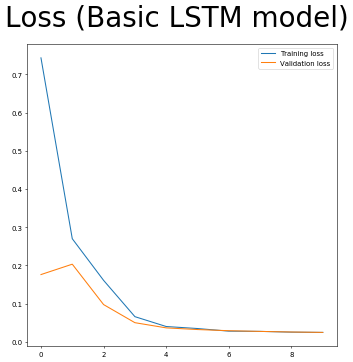

In [9]:
plt.figure(figsize=(8, 8), dpi=50)
plt.suptitle('Loss (Basic LSTM model)', fontsize=40)
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend(['Training loss', 'Validation loss'])
plt.show()

## Validation evaluation
It was seen that after 10 epochs the validation loss stopped going down. After 12 epochs it appeared the model was overfitting, so 10 epochs was chosen. 

## Model 2: LSTM with non-linear scaling
A problem with LSTMs and time series data is that it is difficult to generalise over a wide (in this case, price) scale. This is why we scaled the data to fit between 0 and 1 in preprocessing. An experiment we can perform here is to see if scaling the data again in a non-linear way can help.

The function we will use to the input of the LSTM is log((input) + 1), and we will do the reverse scaling on the output with (exp(output)-1). This will scale down large values more than it scales down small values. The idea behind this is to allow price changes on a small scale to have a larger effect than equivalent changes on a large scale.

For example, if a cryptocurrency with market value \\$1 goes up in value by \\$1, then its value is doubled, which is a significant change. If a currency of value \\$100 goes up by \\$1, then it is a relatively small change.

In [10]:
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 10

class LSTM_SCALED(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_SCALED, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bias=False)
        self.fc1 = nn.Linear(hidden_dim, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, output_dim)

        
    def forward(self, x):
        x = torch.log(x + 1)
        
        out, (hn, cn) = self.lstm(x)
        out = self.fc1(out[:, -1, :]) 
        out = self.fc2(out)
        out = self.fc3(out)
        
        return (torch.exp(out)-1)
    
model_lstm_scaled = LSTM_SCALED(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean').to(device)
optimiser = torch.optim.Adam(model_lstm_scaled.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

training_losses = list()
validation_losses = list()
for t in range(num_epochs):
    train_loss = 0.0
    for x_train, y_train_lstm, _, _, x_test, y_test_lstm in cryptos_prices:
        y_train_pred = model_lstm_scaled(x_train.to(device))
        loss = criterion(y_train_pred, y_train_lstm.to(device))
        print("Epoch ", t, "MSE training: ", loss.item(), end='\r')
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        train_loss += float(loss.item())
    
    val_loss = 0.0
    for x_train, y_train_lstm, x_val, y_val_lstm, _, _ in cryptos_prices:
        y_val_pred = model_lstm_scaled(x_val.to(device))
        loss = criterion(y_val_pred, y_val_lstm.to(device))
        val_loss += float(loss.item())
        
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time), "\nFinal losses:\n  Training loss: ", train_loss, "\n  Validation loss: ", val_loss, end='\r')

Training time: 1.410400629043579 3649744205177
Final losses:
  Training loss:  0.02039655970406784 


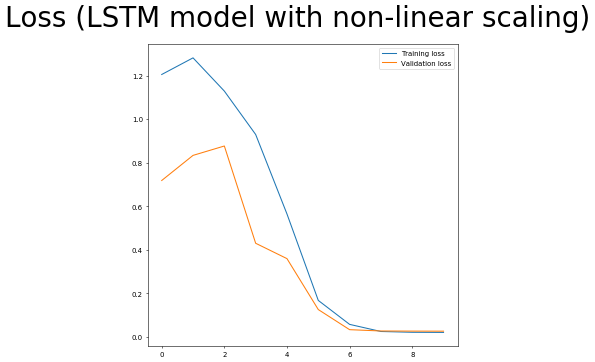

In [11]:
plt.figure(figsize=(8, 8), dpi=50)
plt.suptitle('Loss (LSTM model with non-linear scaling)', fontsize=40)
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend(['Training loss', 'Validation loss'])
plt.show()

We can see that changing the scaling of the data to a non-linear scaling doesn't have a significant effect, as the difference in loss is quite minor. 

## Model 3: GRU
We can test if using another variant of RNN with memory can outperform a standard LSTM. 

In [12]:
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 6

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bias=False)
        self.fc1 = nn.Linear(hidden_dim , 100)
        self.fc2 = nn.Linear(100 , 10)
        self.fc3 = nn.Linear(10, output_dim)

    def forward(self, x):
        out, (hn) = self.gru(x)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean').to(device)
optimiser = torch.optim.Adam(model_gru.parameters(), lr=0.01)


hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

training_losses = list()
validation_losses = list()
for t in range(num_epochs):
    train_loss = 0.0
    for x_train, y_train_lstm, _, _, x_test, y_test_lstm in cryptos_prices:
        y_train_pred = model_gru(x_train.to(device))
        loss = criterion(y_train_pred, y_train_lstm.to(device))
        print("Epoch ", t, "MSE training: ", loss.item(), end='\r')
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        train_loss += float(loss.item())
    
    val_loss = 0.0
    for x_train, y_train_lstm, x_val, y_val_lstm, _, _ in cryptos_prices:
        y_val_pred = model_gru(x_val.to(device))
        loss = criterion(y_val_pred, y_val_lstm.to(device))
        val_loss += float(loss.item())
        
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time), "\nFinal epoch summed losses (MSE):\n  Training: ", train_loss, "\n  Validation: ", val_loss, end='\r')

Training time: 0.7891507148742676 035858243704
Final epoch summed losses (MSE):
  Training:  0.014004082099972948 


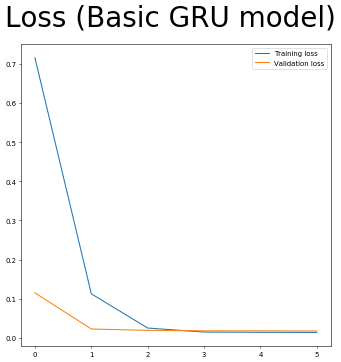

In [13]:
plt.figure(figsize=(8, 8), dpi=50)
plt.suptitle('Loss (Basic GRU model)', fontsize=40)
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend(['Training loss', 'Validation loss'])
plt.show()

## Evaluation
We can now inspect the solutions. We will look at:
- The gold standard
- The output from the LSTM (predicting only one time step, from the real data)
- The projected outputs for each of the models

We can also inspect the MSE of the projected outputs of the models (not just the MSE from the training/validation/test sets). 


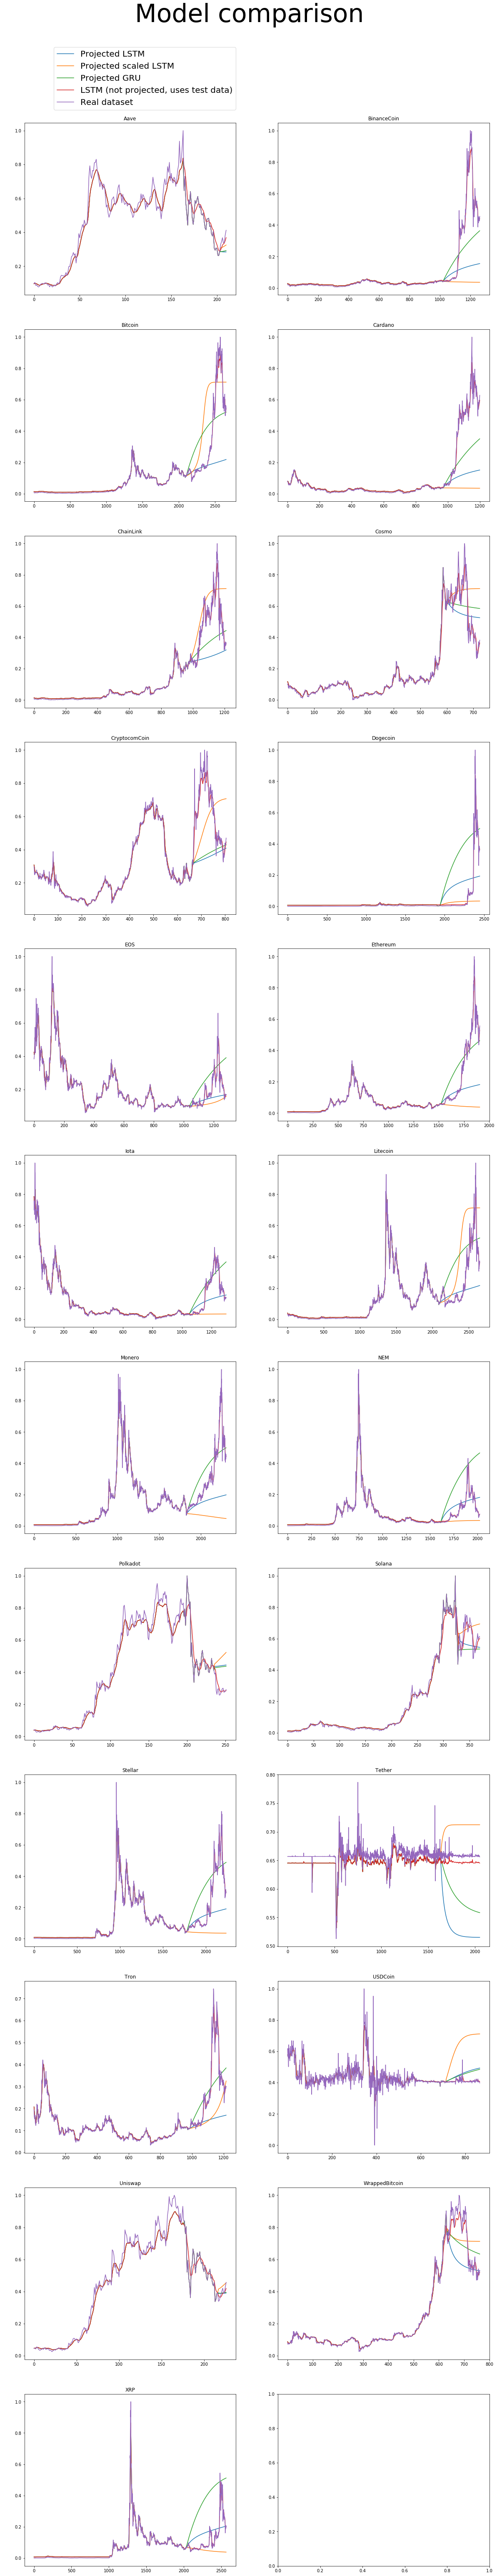

In [14]:
model_lstm.eval()
model_lstm_scaled.eval()
model_gru.eval()
fig, axs = plt.subplots(int(len(cryptos_prices)/2 + 0.5),2)
fig.set_figheight(100)
fig.set_figwidth(20)
fig.suptitle('Model comparison', fontsize=60)
lstm_predicted_all = list()
lstm_scaled_predicted_all = list()
gru_predicted_all = list()
with torch.no_grad():
    for i, data in enumerate(cryptos_prices):
        x_train, y_train, _, _, x_test, y_test = data
        y_train_pred = model_lstm(x_train.to(device)).to('cpu').detach()
        y_test_pred = model_lstm(x_test.to(device)).to('cpu').detach()
        axs[int(i/2), i%2].set_title(cryptos_names[i])
        
        # Predicting/projecting in the 'place' of the testing data. 
        # (Testing data is not used or trained on).
        lstm_pred = torch.zeros(x_test.shape).to(device)
        lstm_pred[0:lookback] = x_test[0:lookback]
        
        lstm_scaled_pred = torch.zeros(x_test.shape).to(device)
        lstm_scaled_pred[0:lookback] = x_test[0:lookback]
        
        gru_pred = torch.zeros(x_test.shape).to(device)
        gru_pred[0:lookback] = x_test[0:lookback]
        
        num_predict_steps = x_test.shape[0]
        for step in range(num_predict_steps-lookback):
            index = step + lookback-1
            
            next_val_lstm = model_lstm(lstm_pred.to(device))[index]*(1)# + 0.05*random.random())
            lstm_pred[index + 1] = torch.cat([lstm_pred[index, 1:], next_val_lstm.unsqueeze(0)], dim=0)
            
            next_val_lstm_scaled = model_lstm_scaled(lstm_scaled_pred)[index]*(1)
            lstm_scaled_pred[index + 1] = torch.cat([lstm_scaled_pred[index, 1:], next_val_lstm_scaled.unsqueeze(0)], dim=0)
            
            next_val_gru = model_gru(gru_pred)[index]*(1)
            gru_pred[index + 1] = torch.cat([gru_pred[index, 1:], next_val_gru.unsqueeze(0)], dim=0)
            
            
        lstm_pred = lstm_pred.to('cpu')
        lstm_predicted_all.append(lstm_pred[:,-1,:])
        
        lstm_scaled_pred = lstm_scaled_pred.to('cpu')
        lstm_scaled_predicted_all.append(lstm_scaled_pred[:,-1,:])
        
        gru_pred = gru_pred.to('cpu')
        gru_predicted_all.append(gru_pred[:,-1,:])
        
        #Plotting the graph
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred,lstm_pred.detach()[:,-1]]))
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred,lstm_scaled_pred.detach()[:,-1]]))
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred,gru_pred.detach()[:,-1]]))
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred.flatten(),y_test_pred.flatten()]))
        axs[int(i/2), i%2].plot(np.concatenate([x_train.squeeze(2)[:,-1],x_test.squeeze(2)[:,-1]]))
        
        
lines, labels = fig.axes[-2].get_legend_handles_labels()
fig.legend(['Projected LSTM', 'Projected scaled LSTM', 'Projected GRU', 'LSTM (not projected, uses test data)', 'Real dataset'], loc='upper right', bbox_to_anchor=(0.4, 0.845), fontsize=20)
plt.subplots_adjust(top=0.94)
plt.show()

Though this model may perform as well (or better) than an LSTM trained on the same number of epochs, we can still train the LSTM for more epochs, and it seems that the predictive power of the LSTM is better (by inspection). If we want to confirm this, we can compute the mean-squared error on the predicted outcomes of the LSTM vs. GRU models. 

In [15]:
all_mse_lstm = list()
all_mse_scaled_lstm = list()
all_mse_gru = list()

for i, (_, _, _, _, _, y_test) in enumerate(cryptos_prices):
    num_of_points = lstm_predicted_all[i].squeeze(1).shape[0]

    mse_lstm = sum((y_test.squeeze(1) - lstm_predicted_all[i].squeeze(1))**2)/num_of_points
    all_mse_lstm.append(mse_lstm)
    
    mse_scaled_lstm = sum((y_test.squeeze(1) - lstm_scaled_predicted_all[i].squeeze(1))**2)/num_of_points
    all_mse_scaled_lstm.append(mse_scaled_lstm)
    
    mse_gru = sum((y_test.squeeze(1) - gru_predicted_all[i].squeeze(1))**2)/num_of_points
    all_mse_gru.append(mse_gru)
    
print('MSE sum for LSTM: ', float(sum(all_mse_lstm)), '\nMSE sum for scaled LSTM: ', float(sum(all_mse_scaled_lstm)), '\nMSE sum for GRU: ', float(sum(all_mse_gru)))

MSE sum for LSTM:  0.867609441280365 
MSE sum for scaled LSTM:  1.0651243925094604 
MSE sum for GRU:  0.6477092504501343


Here we see that the vanilla LSTM is better at predicting the future evaluating by mean-squared-error (MSE) on the projection. This is an interesting result especially when we compare it to the MSE on the training, test and validation sets. 
If we were to evaluate the performance based on these sets directly (in the way we look at MSE under training), then the GRU would be considered to have the best performance. 

The mismatch is due to the fact that we are trying to predict the future price many timesteps in advance, which is not what we do under training. This is an indication that perhaps the way in which our system/experiments are designed do not reflect the way in which we want to use our data, so this could be rectified with another design that takes all this into consideration. 

## Another experiment
Is it possible to introduce bias or randomness into the model to stop it from converging as easily, and does this improve performance of the model?

We will simply add a small value using random.random() to each timestep to create chaos. We can also try a couple of constant bias terms. We will test a couple of different values:

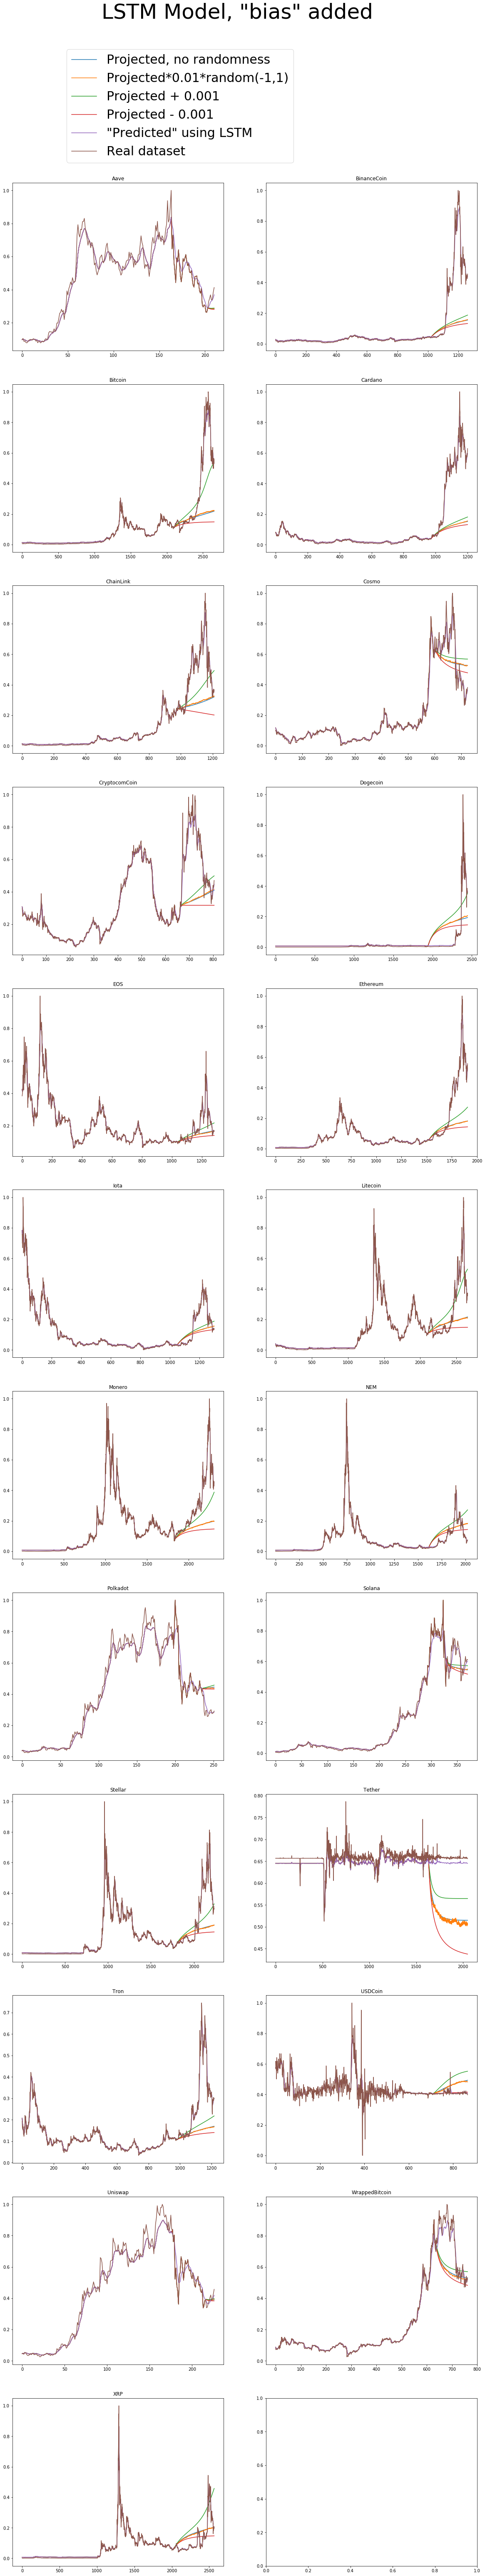

In [16]:
model_lstm.eval()
fig, axs = plt.subplots(int(len(cryptos_prices)/2 + 0.5),2)
fig.set_figheight(100)
fig.set_figwidth(20)
fig.suptitle('LSTM Model, "bias" added', fontsize=50)
lstm_predicted_all_0 = list()
lstm_predicted_all_1 = list()
lstm_predicted_all_2 = list()
lstm_predicted_all_3 = list()
with torch.no_grad():
    for i, data in enumerate(cryptos_prices):
        x_train, y_train, _, _, x_test, y_test = data
        y_train_pred = model_lstm(x_train.to(device)).to('cpu').detach()
        y_test_pred = model_lstm(x_test.to(device)).to('cpu').detach()
        axs[int(i/2), i%2].set_title(cryptos_names[i])
        
        # Predicting/projecting in the 'place' of the testing data. 
        # (Testing data is not used or trained on).
        lstm_pred_0 = torch.zeros(x_test.shape)
        lstm_pred_0[0:lookback] = x_test[0:lookback]
        
        lstm_pred_1 = torch.zeros(x_test.shape)
        lstm_pred_1[0:lookback] = x_test[0:lookback]
        
        lstm_pred_2 = torch.zeros(x_test.shape)
        lstm_pred_2[0:lookback] = x_test[0:lookback]
        
        lstm_pred_3 = torch.zeros(x_test.shape)
        lstm_pred_3[0:lookback] = x_test[0:lookback]
        
        num_predict_steps = x_test.shape[0]
        for step in range(num_predict_steps-lookback):
            index = step + lookback - 1
        
            next_val_0 = model_lstm(lstm_pred_0.to(device)).to('cpu')[index]
            lstm_pred_0[index + 1] = torch.cat([lstm_pred_0[index, 1:], next_val_0.unsqueeze(0)], dim=0)
            
            random_num = 2*random.random()-1  #pseudo-random number between (-1,1)
            next_val_1 = model_lstm(lstm_pred_1.to(device)).to('cpu')[index]*(1 + 0.01*random_num)
            lstm_pred_1[index + 1] = torch.cat([lstm_pred_1[index, 1:], next_val_1.unsqueeze(0)], dim=0)
            
            next_val_2 = model_lstm(lstm_pred_2.to(device)).to('cpu')[index]*(1 + 0.005)
            lstm_pred_2[index + 1] = torch.cat([lstm_pred_2[index, 1:], next_val_2.unsqueeze(0)], dim=0)
            
            next_val_3 = model_lstm(lstm_pred_3.to(device)).to('cpu')[index]*(1 - 0.005)
            lstm_pred_3[index + 1] = torch.cat([lstm_pred_3[index, 1:], next_val_3.unsqueeze(0)], dim=0)
            
        
        lstm_predicted_all_0.append(lstm_pred_0.to('cpu')[:,-1,:])
        lstm_predicted_all_1.append(lstm_pred_1.to('cpu')[:,-1,:])
        lstm_predicted_all_2.append(lstm_pred_2.to('cpu')[:,-1,:])
        lstm_predicted_all_3.append(lstm_pred_3.to('cpu')[:,-1,:])
        
        #Plotting the graph
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred,lstm_pred_0.detach()[:,-1]]))
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred,lstm_pred_1.detach()[:,-1]]))
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred,lstm_pred_2.detach()[:,-1]]))
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred,lstm_pred_3.detach()[:,-1]]))
        
        axs[int(i/2), i%2].plot(np.concatenate([y_train_pred.flatten(),y_test_pred.flatten()]))
        axs[int(i/2), i%2].plot(np.concatenate([x_train.squeeze(2)[:,-1],x_test.squeeze(2)[:,-1]]))
        
        
lines, labels = fig.axes[-2].get_legend_handles_labels()
fig.legend(['Projected, no randomness', 'Projected*0.01*random(-1,1)', 'Projected + 0.001', 'Projected - 0.001','"Predicted" using LSTM', 'Real dataset'], loc='upper right', bbox_to_anchor=(0.5, 0.845), fontsize=30)
plt.subplots_adjust(top=0.92)
plt.show()

In [17]:
all_mse_lstm_0 = list()
all_mse_lstm_1 = list()
all_mse_lstm_2 = list()
all_mse_lstm_3 = list()

for i, (_, _, _, _, _, y_test) in enumerate(cryptos_prices):
    num_of_points = lstm_predicted_all_0[i].squeeze(1).shape[0]
    
    mse_lstm_0 = sum((y_test.squeeze(1) - lstm_predicted_all_0[i].squeeze(1))**2)/num_of_points
    all_mse_lstm_0.append(mse_lstm_0)
    
    mse_lstm_1 = sum((y_test.squeeze(1) - lstm_predicted_all_1[i].squeeze(1))**2)/num_of_points
    all_mse_lstm_1.append(mse_lstm_1)
    
    mse_lstm_2 = sum((y_test.squeeze(1) - lstm_predicted_all_2[i].squeeze(1))**2)/num_of_points
    all_mse_lstm_2.append(mse_lstm_2)
    
    mse_lstm_3 = sum((y_test.squeeze(1) - lstm_predicted_all_3[i].squeeze(1))**2)/num_of_points
    all_mse_lstm_3.append(mse_lstm_3)
    
print('MSE: \nNo randomness: ', float(sum(all_mse_lstm_0)) , '\nProjected*0.01*random(-1,1): ', float(sum(all_mse_lstm_1)), '\nProjected + 0.005: ', float(sum(all_mse_lstm_2)), '\nProjected - 0.005: ', float(sum(all_mse_lstm_3)))

MSE: 
No randomness:  0.867609441280365 
Projected*0.01*random(-1,1):  0.8627385497093201 
Projected + 0.005:  0.6642842888832092 
Projected - 0.005:  1.0202832221984863


Curiously, adding a constant 'bias' term to the output of the model at every time step decreases the MSE of the projection and increases the accuracy of prediction, on average. 

This could be due to that cryptocurrencies generally tend to trend upwards, and the model doesn't capture this so well. Whatever the cause, it would be interesting to know if this is a statistical anomaly or if this represents some lack in the model itself. 